In [1]:
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Lambda
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np
import gym
from gym import wrappers
import time

#import curses
from IPython.display import display, clear_output
import matplotlib.pylab as plt
import cv2

Using TensorFlow backend.


In [2]:
class ReplayBuffer(object):
    def __init__(self, memorySlots, inputShape, numberOfActions, discreteActions=True):
        self.memorySlots = memorySlots
        self.memorySlotCounter = 0
        self.discreteActions = discreteActions
        self.stateMemory = np.zeros((self.memorySlots, *inputShape), dtype=np.uint8)
        self.outcomeStateMemory = np.zeros((self.memorySlots, *inputShape), dtype=np.uint8)
        dtypeForActionMemory = np.int8 if self.discreteActions else np.float32
        self.actionMemory = np.zeros((self.memorySlots, numberOfActions), dtype=dtypeForActionMemory)
        self.rewardMemory = np.zeros(self.memorySlots, dtype=np.int8)
        self.isDoneMemory = np.zeros(self.memorySlots, dtype=np.uint8)

    def store_transition(self, state, action, reward, outcomeState, isDone):
        index = self.memorySlotCounter % self.memorySlots
        self.stateMemory[index] = state
        self.outcomeStateMemory[index] = outcomeState
        if self.discreteActions:
            actions = np.zeros(self.actionMemory.shape[1])
            actions[action] = 1.0
            self.actionMemory[index] = actions
        else:
            self.actionMemory[index] = action
        self.rewardMemory[index] = reward
        self.isDoneMemory[index] = 1 - isDone
        self.memorySlotCounter += 1

    def sample_buffer(self, batchSize):
        max_mem = min(self.memorySlotCounter, self.memorySlots)
        batch = np.random.choice(max_mem, batchSize)

        states = self.stateMemory[batch]
        actions = self.actionMemory[batch]
        rewards = self.rewardMemory[batch]
        outComeStates = self.outcomeStateMemory[batch]
        terminal = self.isDoneMemory[batch]

        return states, actions, rewards, outComeStates, terminal

In [3]:
def buildNeuralNet(learningRate, numberOfActions, inputDimensions, firstLayerNeurons, secondLayerNeurons):
    numberOfFilters = 32
    filterSize = (8, 8)
    filterStride = (4, 4)
    poolSize = (2, 2)
    poolStride = 2
    model = Sequential()
    if len(inputDimensions) == 1:
        model.add(Dense(firstLayerNeurons, input_shape=(*inputDimensions,)))
    else:
        model.add(Lambda(lambda x: x / 255.0, input_shape=(*inputDimensions,), name="NormalizeRGB"))
        model.add(Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), name="CNN-1"))
        model.add(Activation('relu', name="Relu-1"))
        #model.add(MaxPooling2D(pool_size=poolSize, strides=poolStride))

        model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), name="CNN-2"))
        model.add(Activation('relu', name="Relu-2"))
        #model.add(MaxPooling2D(pool_size=poolSize, strides=poolStride))
        model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), name="CNN-3"))
        model.add(Activation('relu', name="Relu-3"))
        model.add(Flatten(name="Flatten-Layer"))
        model.add(Dense(firstLayerNeurons, name="Hidden-1"))
    model.add(Activation('relu', name="Relu-4"))
    model.add(Dense(secondLayerNeurons, name="Hidden-2"))
    model.add(Activation('relu', name="Relu-5"))
    model.add(Dense(numberOfActions, name="Output"))

    model.compile(optimizer=Adam(lr=learningRate), loss='mse')

    return model

In [4]:
class DDQNAgent(object):
    def __init__(self, learningRate, discountFactor, numberOfActions, decisionFactor, batchSize,
                 inputDimensions, DecisionFactorDecayRate=0.996, DecisionFactorMinimum=0.01,
                 memorySlots=1000000, modelName='ddqn_model.h5', updateTargetModelFrequency=100):
        self.actionSpace = np.arange(numberOfActions, dtype=np.uint8)
        self.numberOfActions = numberOfActions
        self.discountFactor = discountFactor
        self.decisionFactor = decisionFactor
        self.decisionFactorDecayRate = DecisionFactorDecayRate
        self.decisionFactorMinimum = DecisionFactorMinimum
        self.batchSize = batchSize
        self.modelName = modelName
        self.updateTargetModelFrequency = updateTargetModelFrequency
        self.memory = ReplayBuffer(memorySlots, inputDimensions, numberOfActions, discreteActions=True)
        self.trainingQNetModel = buildNeuralNet(learningRate, numberOfActions, inputDimensions, 256, 256)
        self.targetQNetModel = buildNeuralNet(learningRate, numberOfActions, inputDimensions, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.decisionFactor:
            action = np.random.choice(self.actionSpace)
        else:
            actions = self.trainingQNetModel.predict(state)
            action = np.argmax(actions)
        return action

    def learn(self):
        if self.memory.memorySlotCounter > self.batchSize:
            state, action, reward, new_state, done = self.memory.sample_buffer(self.batchSize)

            action_values = np.array(self.actionSpace, dtype=np.uint8)
            action_indices = np.dot(action, action_values).astype(np.uint8)

            targetPredictNextAction = self.targetQNetModel.predict(new_state)
            trainingPredictNextAction = self.trainingQNetModel.predict(new_state)
            trainingPredictCurrentAction = self.trainingQNetModel.predict(state)

            bestAction = np.argmax(trainingPredictNextAction, axis=1)

            targetPredictCurrentAction = trainingPredictCurrentAction

            batchIndex = np.arange(self.batchSize, dtype=np.int32)

            targetPredictCurrentAction[batchIndex, action_indices] = reward + \
                self.discountFactor * targetPredictNextAction[batchIndex, bestAction.astype(int)] * done

            _ = self.trainingQNetModel.fit(state, targetPredictCurrentAction, verbose=0)
            
            self.update_decisionFactor()
            
            if self.memory.memorySlotCounter % self.updateTargetModelFrequency == 0:
                self.update_network_parameters()

    def update_decisionFactor(self):
        self.decisionFactor = self.decisionFactor * self.decisionFactorDecayRate if self.decisionFactor > \
                self.decisionFactorMinimum else self.decisionFactorMinimum
        
    def update_network_parameters(self):
        #self.targetQNetModel.set_weights(self.trainingQNetModel.get_weights())
        tau = 0.01
        agent.targetQNetModel.set_weights(
            [(1 -tau) * w for w in agent.trainingQNetModel.get_weights()] + 
            [tau * w for w in agent.trainingQNetModel.get_weights()])

    def save_model(self):
        self.trainingQNetModel.save(self.modelName)

    def load_model(self):
        self.trainingQNetModel = load_model(self.modelName)
        if self.decisionFactor == 0.0:
            self.update_network_parameters()

In [5]:
def rgb2gray(rgb):
    if len(rgb.shape) == 1:
        return rgb
    rgb = cv2.resize(rgb, dsize=(80, 105), interpolation=cv2.INTER_AREA)
    rgb = np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    return rgb
    #dimensions = rgb.shape
    #return rgb.reshape((dimensions[0], dimensions[1], 1))

In [6]:
def printScores(id, gameScore, info, avgScore, decisionFactor):
    if 0:
        stdscr.addstr(0, 0, "Episode {id:d}".format(id=id))
        stdscr.addstr(1, 0, "Current Score: {gameScore:d}   info: {info}".format(gameScore=gameScore, info=info))
        stdscr.addstr(2, 0, "Average Score: {avgScore:.2f} Decision Factor: {decisionFactor:.3f}".format(avgScore=avgScore, decisionFactor=decisionFactor))
        stdscr.refresh()
    else:
        display("Episode {id:.0f}".format(id=id))
        display("Current Score: {gameScore:.0f}    info: {info}".format(gameScore=gameScore, info=info))
        display("Average Score: {avgScore:.2f} Decision Factor: {decisionFactor:.3f}".format(avgScore=avgScore, decisionFactor=decisionFactor))
        clear_output(wait=True)
        time.sleep(0.01)

In [7]:
if __name__ == '__main__':    
    if 0:
        stdscr = curses.initscr()
        curses.noecho()
        curses.cbreak()
    
    print('selecting game', end="                            \r")
    gameLibrary = {1: 'LunarLander-v2', 2: 'Breakout-v0'}
    videoLibrary = {1: './lunar-lander-ddqn-2', 2: './breakout-ddqn-0'}
    modelLibrary = {1: './lunar-lander-ddqn_model.h5', 2: './breakout-ddqn_model.h5'}
    gameSelection = 2

    gameName = gameLibrary.get(gameSelection)
    videoName = videoLibrary.get(gameSelection)
    modelName = modelLibrary.get(gameSelection)

    print("loading game", end="                            \r")
    theGame = gym.make(gameName)
    gameFrame = theGame.reset()
    gameFrame = rgb2gray(gameFrame)
    gameState = np.stack([gameFrame] * 4, axis=2).astype(np.uint8)
    inputDimensions = gameState.shape
    numberOfActions = theGame.action_space.n
        
    print("enter player 1", end="                            \r")
    agent = DDQNAgent(learningRate=0.001, discountFactor=0.99, numberOfActions=numberOfActions, memorySlots=250000,
                      decisionFactor=1.0, batchSize=64, inputDimensions=inputDimensions, modelName=modelName,
                      DecisionFactorDecayRate=0.99996, updateTargetModelFrequency=1)
    
    numberOfGamesToPlay = 5000
    # ddqn_agent.load_model()
    scoreHistory = np.array([0])
    decisionFactorHistory = np.array([1])
    avgScoreHistory = np.array([0])

In [8]:
agent.trainingQNetModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeRGB (Lambda)        (None, 105, 80, 4)        0         
_________________________________________________________________
CNN-1 (Conv2D)               (None, 25, 19, 32)        8224      
_________________________________________________________________
Relu-1 (Activation)          (None, 25, 19, 32)        0         
_________________________________________________________________
CNN-2 (Conv2D)               (None, 11, 8, 64)         32832     
_________________________________________________________________
Relu-2 (Activation)          (None, 11, 8, 64)         0         
_________________________________________________________________
CNN-3 (Conv2D)               (None, 4, 3, 64)          65600     
_________________________________________________________________
Relu-3 (Activation)          (None, 4, 3, 64)         

KeyboardInterrupt: 

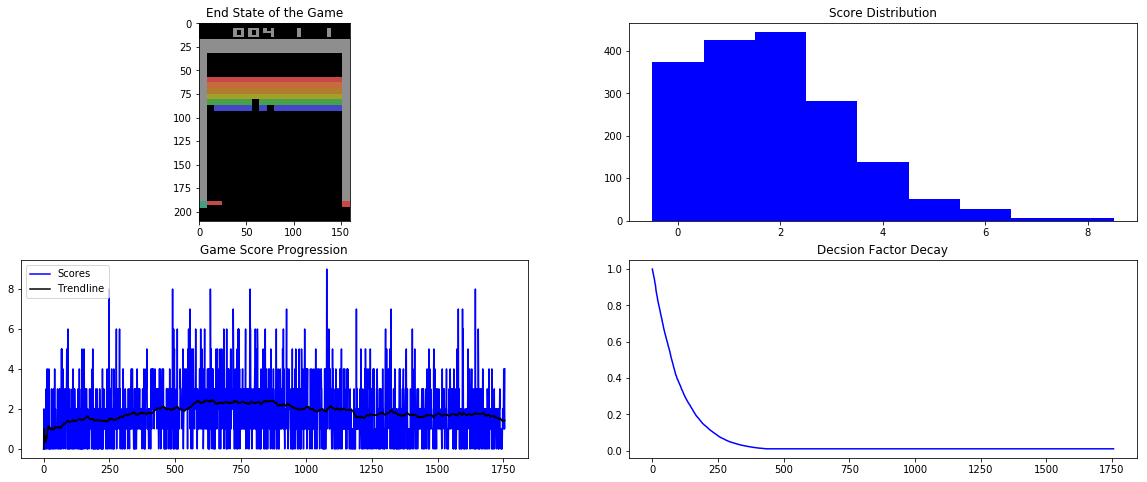

In [9]:
if __name__ == '__main__':
    showVideo = False
    if showVideo:
        theGame = wrappers.Monitor(theGame, videoName, video_callable=lambda episode_id: True, force=True)
    avg_score = 0
    plt.figure(figsize=(20,8))
    plt.subplot(2,2,1)
    plt.title('End State of the Game')
    plt.subplot(2,2,2)
    plt.title('Score Distribution')
    plt.hist([0],[0,1])
    plt.subplot(2,2,3)
    plt.title('Game Score Progression')
    plt.plot([x for x in range(len(scoreHistory))], scoreHistory, 'b')
    plt.plot([x for x in range(len(avgScoreHistory))], avgScoreHistory, 'k')
    plt.legend(('Scores', 'Trendline'), loc='best')
    plt.subplot(2,2,4)
    plt.title('Decsion Factor Decay')
    plt.plot([x for x in range(len(decisionFactorHistory))], decisionFactorHistory, 'b');
    for i in range(numberOfGamesToPlay):
        print('starting game: ', str(i+1), end="                            \r")
        isDone = False
        gameScore = 0
        gameFrame = theGame.reset()
        gameFrame = rgb2gray(gameFrame)
        gameState = np.stack([gameFrame] * 4, axis=2).astype(np.uint8)
        while not isDone:
            action = agent.choose_action(gameState)
            newGameFrame, reward, isDone, info = theGame.step(action)
            if isDone:
                endState = newGameFrame
            newGameFrame = rgb2gray(newGameFrame)
            newGameState = np.append(gameState[:,:,1:], np.expand_dims(newGameFrame+2, 2), axis=2).astype(np.uint8)
            gameScore += reward
            agent.remember(gameState, action, reward, newGameState, int(isDone))
            gameState = newGameState
            agent.learn()
            
            time.sleep(0.1)
            printScores(i + 1, gameScore, info, avg_score, agent.decisionFactor)
            time.sleep(.01)
                        
        decisionFactorHistory = np.append(decisionFactorHistory, agent.decisionFactor)
        #agent.update_decisionFactor()

        scoreHistory = np.append(scoreHistory, gameScore)
        avg_score = np.mean(scoreHistory[max(0, i - 100):(i + 1)])
        avgScoreHistory = np.append(avgScoreHistory, avg_score)
        
        plt.subplot(2,2,1)
        plt.cla()
        plt.title('End State of the Game')
        plt.imshow(endState)
        plt.subplot(2,2,2)
        plt.cla()
        plt.title('Score Distribution')
        plt.hist(scoreHistory, [x for x in range(max(max(scoreHistory), 10))], color='b', align='left')
        plt.subplot(2,2,3)
        plt.cla()
        plt.title('Game Score Progression')
        plt.plot([x for x in range(len(scoreHistory))], scoreHistory, 'b')
        plt.plot([x for x in range(len(avgScoreHistory))], avgScoreHistory, 'k')
        plt.legend(('Scores', 'Trendline'), loc='best')
        plt.subplot(2,2,4)
        plt.cla()
        plt.title('Decsion Factor Decay')
        plt.plot([x for x in range(len(decisionFactorHistory))], decisionFactorHistory, 'b')
        plt.savefig('./thePlot.jpg', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
    agent.save_model()

In [ ]:
#np.zeros((1000, 105, 80, 4), dtype=np.uint8).nbytes / 1024**3

In [18]:
gameState[:,:,2].shape

(105, 80)